In [1]:
# file: image_organizer
# language: Python 3.9
# purpose: create dataframe that organizes images by patient and then type (normal, virus, bacteria)
#          and then redistributes into more balanced train/test/validate subsets
#          based on patient so that all patient images are in the same subset (train/test/validate)
# NOTES: does not read in or process images, just organizes file handles
#        assumes image files are loaded in subdirectory "chest_xray" under directory with this program

# imports
import numpy as np
import pandas as pd
from random import sample
import matplotlib.image as mpimg
import os
import re

import warnings
warnings.filterwarnings("ignore")

base_dir = "./chest_xray/"
sub_dirs = ["test/NORMAL",
            "test/PNEUMONIA",
            "train/NORMAL",
            "train/PNEUMONIA",
            "val/NORMAL",
            "val/PNEUMONIA"]

image_df = pd.DataFrame(columns=["source_file", "source_dir"], dtype="str")
for sub_dir in sub_dirs:
    source_dir = base_dir + sub_dir
    files = os.listdir(base_dir+sub_dir)
    temp_df = pd.DataFrame(files, columns=["source_file"])
    temp_df["source_dir"] = source_dir
    image_df = pd.concat([image_df, temp_df], ignore_index=True)
image_df = image_df.sort_values(["source_dir", "source_file"])

In [2]:
image_df

,source_file,source_dir
216,IM-0001-0001.jpeg,./chest_xray/test/NORMAL
93,IM-0003-0001.jpeg,./chest_xray/test/NORMAL
75,IM-0005-0001.jpeg,./chest_xray/test/NORMAL
116,IM-0006-0001.jpeg,./chest_xray/test/NORMAL
174,IM-0007-0001.jpeg,./chest_xray/test/NORMAL
...,...,...
5854,person1949_bacteria_4880.jpeg,./chest_xray/val/PNEUMONIA
5848,person1950_bacteria_4881.jpeg,./chest_xray/val/PNEUMONIA
5849,person1951_bacteria_4882.jpeg,./chest_xray/val/PNEUMONIA
5850,person1952_bacteria_4883.jpeg,./chest_xray/val/PNEUMONIA


In [3]:
# set image type: normal, bacterial penumonia or viral pneumonia
types = ["normal", "bacteria", "virus"]
image_df["type"] = "normal"
image_df["type"] = np.where(image_df["source_file"].str.contains("virus"), "virus", image_df["type"])
image_df["type"] = np.where(image_df["source_file"].str.contains("bacteria"), "bacteria", image_df["type"])
for type in types:
    type_df = image_df[image_df.type == type]

In [5]:
# extract patient number from filename
def extract_patient(source_file):
    patient = ""
    if "virus" in source_file:
        patient = str.split(source_file, "_")[0][6:]
    if "bacteria" in source_file:
        patient = str.split(source_file, "_")[0][6:]
    if "NORMAL" in source_file:
        patient = str.split(source_file, "-")[2]
    else:
        if "IM" in source_file:
            patient = str.split(source_file, "-")[1]
    return(int(patient))

image_df["patient"] = image_df["source_file"].apply(extract_patient)

In [7]:
# save copy of intermediate dataframe
image_df.to_csv('./chest_xray/image_df.csv')

In [8]:
# create bucketized dataframe
# where each row represents a patient
# and their are separate columns for images and image counts by type
patients = list(image_df.patient.unique())
xray_data = []
for patient in patients:
    bytype = []
    for type in types:
        subset = image_df[(image_df.patient == patient) & (image_df.type == type)].copy()
       # subset["source"] = subset.source_file
        subset["source"] = subset.source_dir + "/" + subset.source_file
        bytype.append(list(subset["source"]))
    xray_data.append((patient, bytype[0], bytype[1], bytype[2]))
xray_data_df = pd.DataFrame(xray_data, columns=["patient", "normal", "bacteria", "virus"])


In [9]:
# track count of images
def image_count(image_list):
    return len(image_list)
for type in types:
    xray_data_df[type+"_count"] = xray_data_df[type].apply(image_count)
xray_data_df.to_csv('./chest_xray/grouped_image_df.csv')

In [10]:
# partition patients between train, test & validation sets
# note the balancing won't be exact as the number of images of each type vary by patient
# but trials seem to show it provides a reasonable distribution
count = xray_data_df.shape[0]
# proportion of sample for training
train_proportion = 0.6

# shuffle patients
xray_data_df = xray_data_df.sample(frac=1).reset_index(drop=True)

In [11]:
# label sets
xray_data_df["set"] = "train"
train_count = int(count * train_proportion)
test_count = int((count-train_count)/2)
xray_data_df.set[train_count:test_count + train_count] = "test"
# validation set will get whatever is left over ~ approximately same size as test
xray_data_df.set[test_count + train_count:] = "validate"

# display results of oversampling
for set in ["train", "test", "validate"]:
    temp_df = xray_data_df[xray_data_df.set == set]
    print("set", set,
          "normal", np.sum(temp_df.normal_count),
          "bacteria", np.sum(temp_df.bacteria_count),
          "virus", np.sum(temp_df.virus_count))

# export df to files (csv to browse, json to retrieve)
xray_data_df.to_json('./chest_xray/xray_data_df.json')
xray_data_df.to_csv('./chest_xray/xray_data_df.csv')

set train normal 939 bacteria 1671 virus 869
set test normal 335 bacteria 576 virus 301
set validate normal 309 bacteria 533 virus 323


In [12]:
# file resample_images
# language: Python 3.9
# purpose: resample (oversample) images to correct imbalance between normal, virus & bacteria

# imports
import numpy as np
import pandas as pd
from random import choices, randint
import matplotlib.image as mpimg
import os
import re


# load xray_data_df
xray_data_df = pd.read_json('./chest_xray/xray_data_df.json')

# oversample by set (to prevent contaminating test & validate sets)
# get list of sets & types from data)
sets = ["train", "test", "validate"]
types = ["normal", "bacteria", "virus"]
other_types = ["normal", "virus"]
print(xray_data_df.iloc[0:5])
print("columns", xray_data_df.columns)


   patient                                             normal  \
0     1603                                                 []   
1      798  [./chest_xray/train/NORMAL/NORMAL2-IM-0798-000...   
2     1510                                                 []   
3       83       [./chest_xray/test/NORMAL/IM-0083-0001.jpeg]   
4     1942                                                 []   

                                            bacteria  \
0                                                 []   
1                                                 []   
2                                                 []   
3  [./chest_xray/test/PNEUMONIA/person83_bacteria...   
4  [./chest_xray/train/PNEUMONIA/person1942_bacte...   

                                               virus  normal_count  \
0  [./chest_xray/train/PNEUMONIA/person1603_virus...             0   
1  [./chest_xray/train/PNEUMONIA/person798_virus_...             1   
2  [./chest_xray/train/PNEUMONIA/person1510_virus...          

In [13]:
for set in sets:
    print("set", set)
    temp_df = xray_data_df[xray_data_df["set"] == set]
    # since bacteria count is always higher than other types
    # we will use bacteria count to oversample other image types
    target_sample = np.sum(temp_df.bacteria_count)

    # oversample normal
    temp2_df = temp_df[temp_df.normal_count > 0]
    patients = list(temp2_df.patient)
    sample = np.sum(temp_df["normal_count"])
    # compute needed sample
    needed_sample = target_sample - sample

    # pull additional samples with replacement
    # samples pulled by patient not by image so as not to overweight patients with multiple images
    # for each sampled patient one normal image is added to the sample
    samples = choices(patients, k=needed_sample)

    # iterate through sample
    for sample in samples:
        images = xray_data_df.normal[xray_data_df["patient"] == sample].iloc[0]
        count = xray_data_df.normal_count[xray_data_df["patient"] == sample].iloc[0]
        if count > 1:
            added_image = images[randint(0, count - 1)]
        else:
            added_image = images[0]
        xray_data_df.normal[xray_data_df.patient == sample].iloc[0].append(added_image)
        xray_data_df.normal_count[xray_data_df.patient == sample] = count + 1

    # oversample virus
    temp2_df = temp_df[temp_df.virus_count > 0]
    patients = list(temp2_df.patient)
    sample = np.sum(temp_df["virus_count"])
    # compute needed sample
    needed_sample = target_sample - sample

    # pull additional samples with replacement
    # samples pulled by patient not by image so as not to overweight patients with multiple images
    # for each sampled patient one normal image is added to the sample
    samples = choices(patients, k=needed_sample)

    # iterate through sample
    for sample in samples:
        images = xray_data_df.virus[xray_data_df["patient"] == sample].iloc[0]
        count = xray_data_df.virus_count[xray_data_df["patient"] == sample].iloc[0]
        if count > 1:
            added_image = images[randint(0, count - 1)]
        else:
            added_image = images[0]
        xray_data_df.virus[xray_data_df.patient == sample].iloc[0].append(added_image)
        xray_data_df.virus_count[xray_data_df.patient == sample] = count + 1


for set in ["train", "test", "validate"]:
    temp_df = xray_data_df[xray_data_df.set == set]
    print("set", set,
          "normal", np.sum(temp_df.normal_count),
          "bacteria", np.sum(temp_df.bacteria_count),
          "virus", np.sum(temp_df.virus_count))

xray_data_df.to_json('./chest_xray/xray_balanced_data_df.json')
xray_data_df.to_csv('./chest_xray/xray_balanced_data_df.csv')


set train
set test
set validate
set train normal 1671 bacteria 1671 virus 1671
set test normal 576 bacteria 576 virus 576
set validate normal 533 bacteria 533 virus 533


In [14]:
"""
Title: Translate Resampled Directories To Data Table
Created on Mon Jul 17 17:53:39 2023
@author: nccru
"""

# %% import packages
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA

In [15]:
# %% extract each image into a new file
def read_path_assignments_to_tuple_list(filepath, image_size = 150):
    """
    Description 
    -------
    Takes the file generated from the resample_images.py file and creates
    a series of three lists of tuples. Each tuple element is a list of 
    [set, patient id, class id, vectorized image].
    
    Inputs
    -------
    `filepath` = Path to the csv file output from the resample_images.py file
    `image_size` = n x n size of the compressed image we want for the sake of
        standardization, as each image may have different baseline dimensions
    
    Returns
    -------
    `train` = list of tuples containing records associated with the training
        data set.
        
    `test` = list of tuples containing records associated with the testing
        data set.
        
    `val` = list of tuples containing records associated with the validation
        data set.
    """
    # read data
    df = pd.read_csv(filepath)
    
    # iterate through each row
    train, test, val = [], [], []
    for i in df.itertuples(index = False):
        # print('--- Patient {} ---'.format(i.patient))
        # extract file paths
        norm_paths = i.normal.strip('[]').split(',')
        bac_paths = i.bacteria.strip('[]').split(',')
        vir_paths = i.virus.strip('[]').split(',')
        
        # read in the images
        def read_image(img_path, img_size = image_size):
            p = re.sub(r"'", '', img_path).strip() # clean up path name
            img_arr = cv2.imread(p, cv2.IMREAD_GRAYSCALE) 
            img_resize = cv2.resize(img_arr, (img_size, img_size)).flatten()
            img_resize_scaled = img_resize / 255
            return img_resize_scaled
        
        def store_image(img_arr, class_id):
            if i.set == 'train':
                train.append((i.set, i.patient, class_id, img_arr))
            elif i.set == 'test':
                test.append((i.set, i.patient, class_id, img_arr))
            else:
                val.append((i.set, i.patient, class_id, img_arr))
            
        ## normal
        for path in norm_paths:
            # print(path)
            if len(path) > 0:
                img = read_image(path)
                store_image(img, 'normal')
        
        ## bacteria
        for path in bac_paths:
            if len(path) > 0:
                img = read_image(path)
                store_image(img, 'bacteria')
                
        ## virus
        for path in vir_paths:
            if len(path) > 0:
                img = read_image(path)
                store_image(img, 'virus')
    
    return train, test, val


In [16]:
# %% convert list of tuples into relevant shapes for plotting
def convert_tuple_list_to_sklearn_objects(train, test, val):
    """
    Description
    -------
    Given a collection of tuple lists [train, test, val], join them all
    together and reshape them meaningfully.
    
    Inputs 
    -------
    `train`, `test`, `val` = Tuple lists from the function 
        read_path_assignments_to_tuple_list
    

    Returns
    -------
    `sets` = An array of defining which set each sample belongs to.
    `y` = The labels for each vectorized image.
    `X` = The vectorized images

    """
    t = train + test + val # stack all lists together
    sets = [set_id for (set_id, patient_id, class_id, arr) in t]
    y = [class_id for (set_id, patient_id, class_id, arr) in t]
    X = np.stack([arr for (set_id, patient_id, class_id, arr) in t])
    
    return sets, y, X

In [17]:
# %% perform PCA on X to reduce dimensionality
def pca_and_convert_to_pandas(X, y, sets, pca_dim = 20):
    """
    Description
    -------
    Given a set of vectorized images `X`, their class labels `y`, and which 
    `sets` they belong to, perform PCA to reduce the dimensionality down to
    `pca_dim`. Then store that as a df.

    Inputs
    -------
    `X` = The vectorized image array
    `y` = The class the image is associated with
    `sets` = The [train, test, val] assignements
    `pca_dim` = The number of dimensions to reduce to

    Returns
    ------
    `df` = The pandas data frame representation of reduced images.

    """
    X_pca = PCA(n_components = pca_dim).fit_transform(X)  
    colnames = ['pca' + str(i) for i in range(pca_dim)]
    df = pd.DataFrame(X_pca, columns = colnames)
    df['y'] = y
    df['set'] = sets 

    return df

In [18]:
# %% run through workflow and save to csv
fpath = './chest_xray/xray_balanced_data_df.csv'
train, test, val = read_path_assignments_to_tuple_list(fpath)
sets, y, X = convert_tuple_list_to_sklearn_objects(train, test, val)
final_df = pca_and_convert_to_pandas(X, y, sets)
final_df.to_csv('Pnuemonia Images PCA Reduced.csv')

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

from xgboost import XGBClassifier

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

import warnings
warnings.filterwarnings("ignore")

In [20]:
final_df.replace({'normal':0, 'virus': 1, 'bacteria': 2},inplace=True)

In [21]:
X_train = final_df[final_df['set']=='train'].drop(['y', 'set'], axis=1).to_numpy()
X_test  = final_df[final_df['set']=='test'].drop(['y', 'set'], axis=1).to_numpy()
X_val  = final_df[final_df['set']=='validate'].drop(['y', 'set'], axis=1).to_numpy()

In [22]:
y_train = final_df['y'][final_df['set']=='train'].to_numpy()
y_test = final_df['y'][final_df['set']=='test'].to_numpy()
y_val = final_df['y'][final_df['set']=='validate'].to_numpy()

In [23]:
#making an instance of each algorithm
knn = KNeighborsClassifier(n_neighbors = 10)
log_reg  = LogisticRegression(multi_class='ovr', solver='liblinear')
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC()
xgb = XGBClassifier()

In [24]:
#fitting each model using X_train and y_train
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [25]:
#scoring each model
print('KNN accuracy score is: ' + str(knn.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))

KNN accuracy score is: 0.7378472222222222
Logistic Regression accuracy score is: 0.7366898148148148
Decision Tree Classifier accuracy score is: 0.6527777777777778
Random forests Classifier accuracy score is: 0.7609953703703703
Support Vector Machine Classifier accuracy score is: 0.7743055555555556


In [26]:
xgb_predicted = xgb.predict(X_test)
print('XGBoost accuracy score is: ' + str(accuracy_score(y_test,xgb_predicted)))

XGBoost accuracy score is: 0.7615740740740741


In [27]:
#making predictions for each model
knn_predicted = knn.predict(X_test)
log_reg_predicted = log_reg.predict(X_test)
dtc_predicted = dtc.predict(X_test)
rfc_predicted = rfc.predict(X_test)
svm_predicted = svm.predict(X_test)

In [28]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
    labels = ['Normal', 'virus', 'bacteria']
    cm = confusion_matrix(y_test,predictions)
    cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
    plt.figure(figsize = (7,7))
    plt.title(title)
    sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
    plt.show()

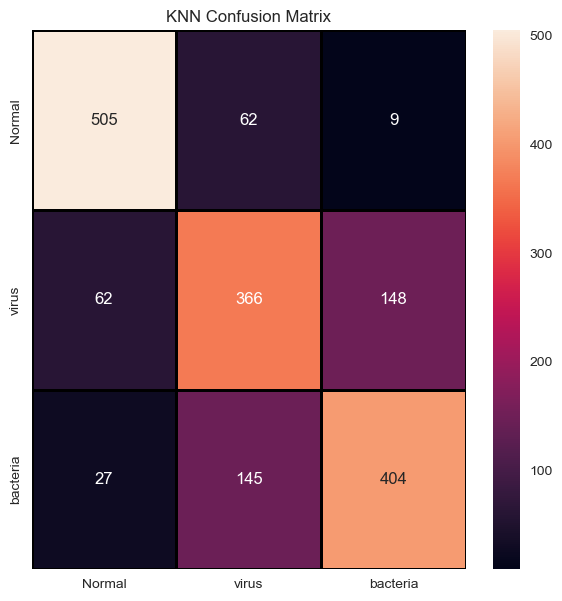

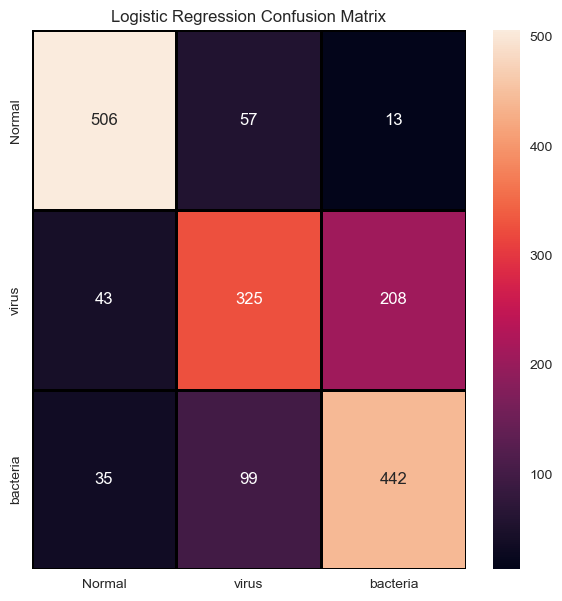

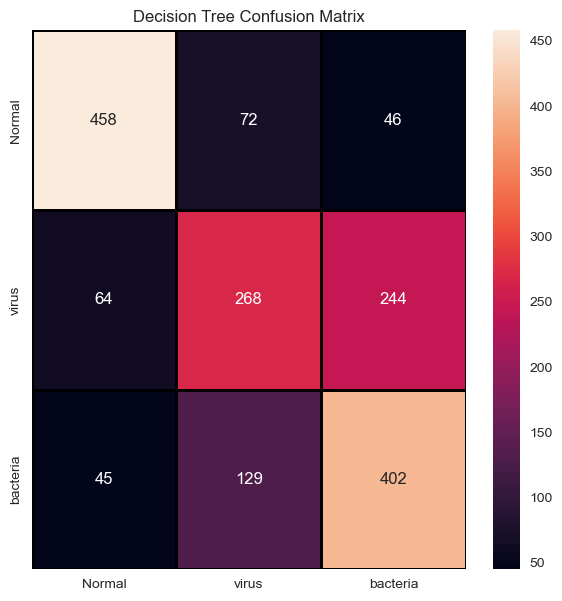

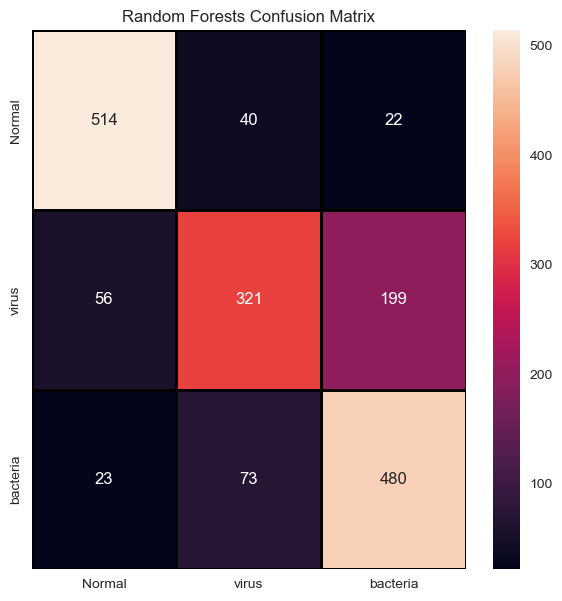

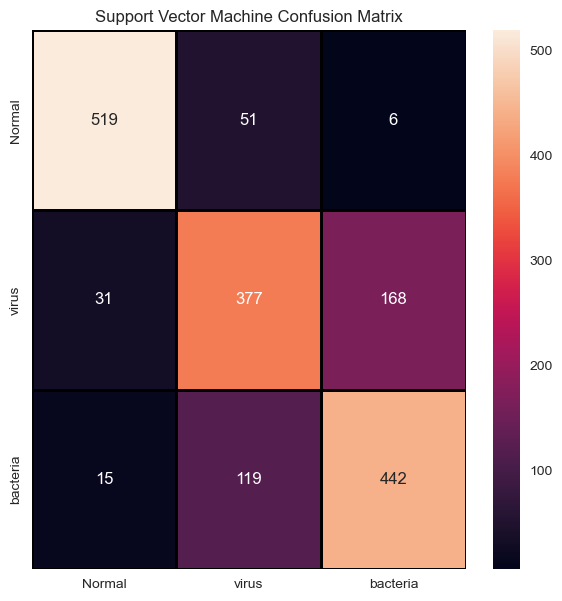

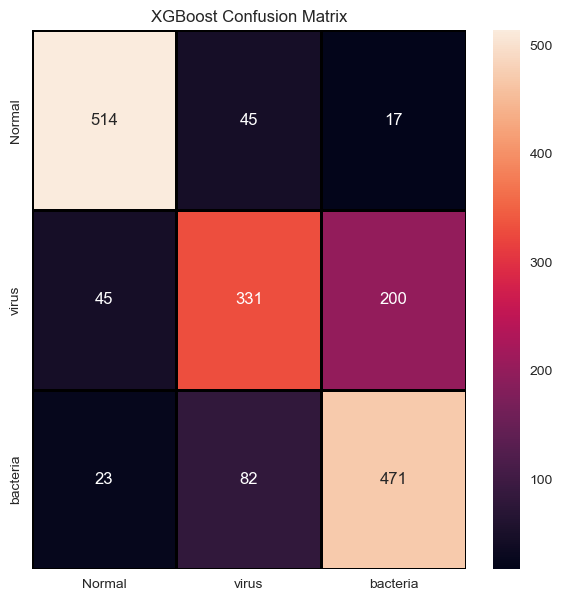

In [29]:
#plot confusion matrix for each model
plot_cm(knn_predicted, y_test, 'KNN Confusion Matrix')
plot_cm(log_reg_predicted, y_test, 'Logistic Regression Confusion Matrix') 
plot_cm(dtc_predicted, y_test, 'Decision Tree Confusion Matrix')
plot_cm(rfc_predicted, y_test, 'Random Forests Confusion Matrix')
plot_cm(svm_predicted, y_test, 'Support Vector Machine Confusion Matrix')
plot_cm(xgb_predicted, y_test, 'XGBoost Confusion Matrix')

In [30]:
#KNN classification report 
print(classification_report(y_test, knn_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)']))

              precision    recall  f1-score   support

  Normal (0)       0.85      0.88      0.86       576
   Virus (1)       0.64      0.64      0.64       576
Bacteria (2)       0.72      0.70      0.71       576

    accuracy                           0.74      1728
   macro avg       0.74      0.74      0.74      1728
weighted avg       0.74      0.74      0.74      1728



In [31]:
#Logistic Regression classification report 
print(classification_report(y_test, log_reg_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)']))

              precision    recall  f1-score   support

  Normal (0)       0.87      0.88      0.87       576
   Virus (1)       0.68      0.56      0.61       576
Bacteria (2)       0.67      0.77      0.71       576

    accuracy                           0.74      1728
   macro avg       0.74      0.74      0.73      1728
weighted avg       0.74      0.74      0.73      1728



In [32]:
#Decision Tree classification report 
print(classification_report(y_test, dtc_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)']))

              precision    recall  f1-score   support

  Normal (0)       0.81      0.80      0.80       576
   Virus (1)       0.57      0.47      0.51       576
Bacteria (2)       0.58      0.70      0.63       576

    accuracy                           0.65      1728
   macro avg       0.65      0.65      0.65      1728
weighted avg       0.65      0.65      0.65      1728



In [33]:
#Random Forest classification report 
print(classification_report(y_test, rfc_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)']))

              precision    recall  f1-score   support

  Normal (0)       0.87      0.89      0.88       576
   Virus (1)       0.74      0.56      0.64       576
Bacteria (2)       0.68      0.83      0.75       576

    accuracy                           0.76      1728
   macro avg       0.76      0.76      0.76      1728
weighted avg       0.76      0.76      0.76      1728



In [34]:
#SVM classification report 
print(classification_report(y_test, svm_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)']))

              precision    recall  f1-score   support

  Normal (0)       0.92      0.90      0.91       576
   Virus (1)       0.69      0.65      0.67       576
Bacteria (2)       0.72      0.77      0.74       576

    accuracy                           0.77      1728
   macro avg       0.78      0.77      0.77      1728
weighted avg       0.78      0.77      0.77      1728



In [35]:
#XGBoost classification report 
print(classification_report(y_test, xgb_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)']))

              precision    recall  f1-score   support

  Normal (0)       0.88      0.89      0.89       576
   Virus (1)       0.72      0.57      0.64       576
Bacteria (2)       0.68      0.82      0.75       576

    accuracy                           0.76      1728
   macro avg       0.76      0.76      0.76      1728
weighted avg       0.76      0.76      0.76      1728



### Hyperparamter tuning

In [36]:
#knn tunning
knn = KNeighborsClassifier()
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 19 candidates, totalling 190 fits
{'n_neighbors': 19}
Accuracy for our training dataset with tuning is : 72.63%


Accuracy for our testing dataset with tuning is : 74.07%


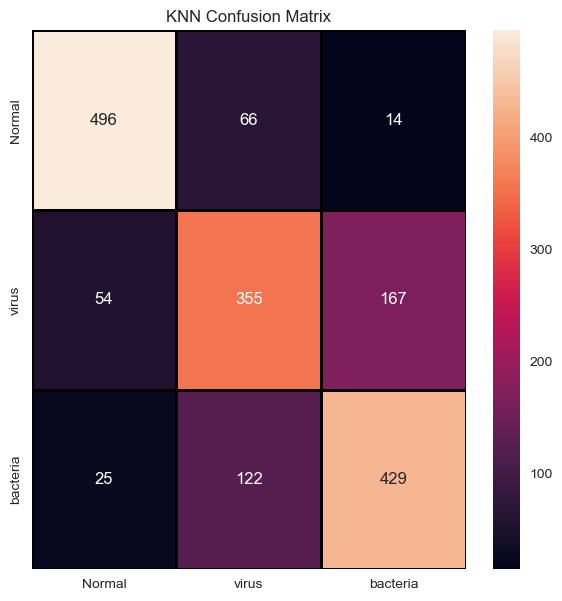

In [41]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)
y_test_hat=knn.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'KNN Confusion Matrix')

In [38]:
#logistic regression tunning
log = LogisticRegression()
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
 
# defining parameter range
grid = GridSearchCV(log, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 42 candidates, totalling 420 fits
{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy for our training dataset with tuning is : 74.01%


Accuracy for our testing dataset with tuning is : 74.54%


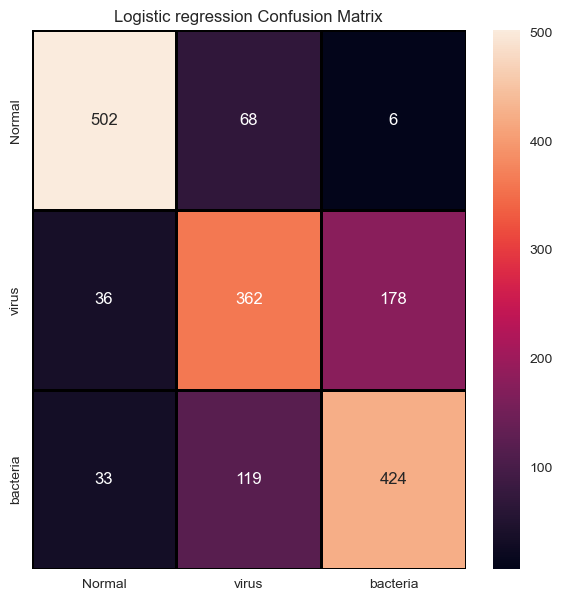

In [42]:
log = LogisticRegression(C= 0.01, penalty= 'l2', solver= 'newton-cg')
log.fit(X_train, y_train)
y_test_hat=log.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'Logistic regression Confusion Matrix')

In [43]:
#Decision Tree tunning
dtc = DecisionTreeClassifier()
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth' : range(1,10),
    'min_samples_split': range(1,10),
    'min_samples_leaf': range(1,5),
}
 
# defining parameter range
grid = GridSearchCV(dtc, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 7}
Accuracy for our training dataset with tuning is : 69.84%


Accuracy for our testing dataset with tuning is : 73.03%


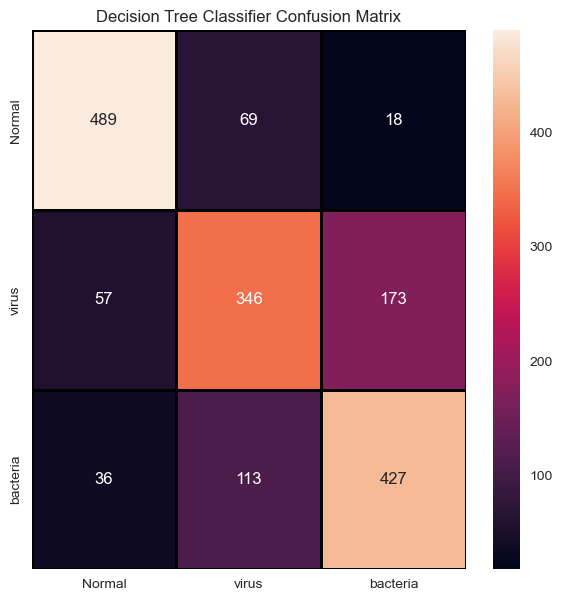

In [44]:
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth= 6, min_samples_split= 7, min_samples_leaf = 4)
dtc.fit(X_train, y_train)
y_test_hat=dtc.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'Decision Tree Classifier Confusion Matrix')

In [ ]:
#Random Forest tunning
rfc = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': range(1,10),
    'min_samples_split': range(1,10),
    'min_samples_leaf': range(1,5),
}
 
# defining parameter range
grid = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy', return_train_score=True,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

Fitting 10 folds for each of 972 candidates, totalling 9720 fits


In [ ]:
rfc = RandomForestClassifier(n_estimators = 100, max_depth= 5, min_samples_split= 2, min_samples_leaf = 5)
rfc.fit(X_train, y_train)
y_test_hat=rfc.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'Random Forest Classifier Confusion Matrix')

In [ ]:
#SVM tunning
svm = SVC()
param_grid = { 
    'C':[0.1,1,100,1000],
    'kernel':['rbf','poly','sigmoid','linear'],
    'degree':[1,2,3,4,5,6],
    'gamma': [1, 0.1, 0.01, 0.05, 0.001]
    }
# defining parameter range
grid = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
svm = SVC(C = , kernel = '', degree= 5, gamma= 2)
svm.fit(X_train, y_train)
y_test_hat=svm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'SVM Classifier Confusion Matrix')

In [ ]:
#XGBoost tunning
xgb = XGBClassifier()
param_grid = = {
    'max_depth': range (1, 10),
    'n_estimators': [100, 200, 400],
    'learning_rate': [1, 0.1, 0.01, 0.05, 0.001]
}
# defining parameter range
grid = GridSearchCV(xgb, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
xgb = XGBClassifier(max_depth = , n_estimators = '', learning_rate = 5)
xgb.fit(X_train, y_train)
y_test_hat=xgb.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'XGBoost Classifier Confusion Matrix')